In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional, Union, Tuple
import copy
from scipy.stats import multivariate_normal
from types import SimpleNamespace
import math
from das.smc_utils import compute_ess_from_log_w, normalize_log_weights, resampling_function, normalize_weights, adaptive_tempering

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

import torch
import random
import torch.backends.cudnn as cudnn

torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)
np.random.seed(42)
cudnn.benchmark = False
cudnn.deterministic = True
random.seed(42)

Using device: cuda


## Define Functions and Classes for Diffusion

In [2]:
class SimpleUNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 64),  # 2D input + time
            nn.ReLU(),
            # nn.Linear(64, 128),
            # nn.ReLU(),
            # nn.Linear(128, 64),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 2)  # 2D output
        )

    def forward(self, x, t):
        x = torch.cat([x, t.unsqueeze(-1)], dim=-1)
        return self.net(x)

In [3]:
def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

class DDIMScheduler:
    def __init__(self, num_train_timesteps=1000, beta_start=0.0001, beta_end=0.02, device='cpu'):
        self.num_train_timesteps = num_train_timesteps
        
        self.betas = linear_beta_schedule(num_train_timesteps, beta_start, beta_end).to(device)
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        
        self.final_alpha_cumprod = self.alphas_cumprod[0]
        self.num_inference_steps = None
        
    def set_timesteps(self, num_inference_steps):
        self.num_inference_steps = num_inference_steps
        self.timesteps = torch.linspace(self.num_train_timesteps - 1, 0, num_inference_steps, dtype=torch.long)
        
    def _get_variance(self, timestep, prev_timestep):
        alpha_prod_t = self.alphas_cumprod[timestep]
        alpha_prod_t_prev = torch.where(
            prev_timestep >= 0,
            self.alphas_cumprod[prev_timestep],
            self.final_alpha_cumprod
        )
        beta_prod_t = 1 - alpha_prod_t
        beta_prod_t_prev = 1 - alpha_prod_t_prev
        
        variance = (beta_prod_t_prev / beta_prod_t) * (1 - alpha_prod_t / alpha_prod_t_prev)
        return variance

In [4]:
def ddim_step_with_logprob(
    scheduler,
    model_output: torch.FloatTensor,
    timestep: int,
    sample: torch.FloatTensor,
    eta: float = 0.0,
    prev_sample: Optional[torch.FloatTensor] = None,
) -> Tuple[torch.FloatTensor, torch.FloatTensor]:
    """
    Perform a single DDIM step with log probability calculation.
    
    Args:
        scheduler: The DDIMScheduler object.
        model_output: The output from the UNet model.
        timestep: The current timestep.
        sample: The current sample (x_t).
        eta: The eta parameter for adding noise (0 for DDIM, 1 for DDPM).
        prev_sample: Optional; the previous sample (x_{t-1}) if available.
    
    Returns:
        A tuple containing:
        - The previous sample (x_{t-1})
        - The log probability of the step
    """
    # 1. get previous step value (=t-1)
    prev_timestep = timestep - scheduler.num_train_timesteps // scheduler.num_inference_steps

    # 2. compute alphas, betas
    alpha_prod_t = scheduler.alphas_cumprod[timestep]
    alpha_prod_t_prev = torch.where(
        prev_timestep >= 0,
        scheduler.alphas_cumprod[prev_timestep],
        scheduler.final_alpha_cumprod
    )

    beta_prod_t = 1 - alpha_prod_t

    # 3. compute predicted original sample from predicted noise
    pred_original_sample = (sample - beta_prod_t.sqrt().unsqueeze(-1) * model_output) / alpha_prod_t.sqrt().unsqueeze(-1)
    
    # 4. compute variance
    variance = scheduler._get_variance(timestep, prev_timestep)
    std_dev_t = eta * variance.sqrt()

    # 5. compute "direction pointing to x_t" of formula (12) from https://arxiv.org/pdf/fontsize10.02502.pdf
    pred_sample_direction = (1 - alpha_prod_t_prev - std_dev_t**2).sqrt().unsqueeze(-1) * model_output

    # 6. compute x_t without "random noise" of formula (12) from https://arxiv.org/pdf/2010.02502.pdf
    prev_sample_mean = alpha_prod_t_prev.sqrt().unsqueeze(-1) * pred_original_sample + pred_sample_direction

    # 6. Add noise
    if prev_sample is None:
        noise = torch.randn(model_output.shape, device=device, dtype=model_output.dtype)
        prev_sample = prev_sample_mean + std_dev_t.unsqueeze(-1) * noise
    
    # 7. Compute log probability
    log_prob = _compute_gaussian_log_prob(prev_sample, prev_sample_mean, std_dev_t.unsqueeze(-1)).mean(-1)

    return prev_sample, log_prob

def _compute_gaussian_log_prob(x, mean, std):
    """Compute log probability for Gaussian distribution."""
    log_scale = torch.log(std)
    return -((x - mean) ** 2) / (2 * std ** 2) - log_scale - math.log(math.sqrt(2 * math.pi))

In [5]:
def ddim_step_KL(
    scheduler: DDIMScheduler,
    model_output: torch.FloatTensor,
    old_model_output: torch.FloatTensor,
    timestep: torch.LongTensor,
    sample: torch.FloatTensor,
    eta: float = 0.0,
    generator=None,
    variance_noise: Optional[torch.FloatTensor] = None,
) -> Union[Tuple[torch.FloatTensor, torch.FloatTensor], Tuple]:
    
    # 1. get previous step value (=t-1)
    prev_timestep = timestep - scheduler.num_train_timesteps // scheduler.num_inference_steps

    # 2. compute alphas, betas
    alpha_prod_t = scheduler.alphas_cumprod[timestep]
    alpha_prod_t_prev = torch.where(
        prev_timestep >= 0,
        scheduler.alphas_cumprod[prev_timestep],
        scheduler.final_alpha_cumprod
    )

    beta_prod_t = 1 - alpha_prod_t

    # 3. compute predicted original sample from predicted noise
    pred_original_sample = (sample - beta_prod_t.sqrt().unsqueeze(-1) * model_output) / alpha_prod_t.sqrt().unsqueeze(-1)
    old_pred_original_sample = (sample - beta_prod_t.sqrt().unsqueeze(-1) * old_model_output) / alpha_prod_t.sqrt().unsqueeze(-1)

    # 4. compute variance
    variance = scheduler._get_variance(timestep, prev_timestep)
    std_dev_t = eta * variance.sqrt()

    # 5. compute "direction pointing to x_t" of formula (12) from https://arxiv.org/pdf/2010.02502.pdf
    pred_sample_direction = (1 - alpha_prod_t_prev - std_dev_t**2).sqrt().unsqueeze(-1) * model_output
    old_pred_sample_direction = (1 - alpha_prod_t_prev - std_dev_t**2).sqrt().unsqueeze(-1) * old_model_output

    # 6. compute x_t without "random noise" of formula (12) from https://arxiv.org/pdf/2010.02502.pdf
    prev_sample_mean = alpha_prod_t_prev.sqrt().unsqueeze(-1) * pred_original_sample + pred_sample_direction
    old_prev_sample_mean = alpha_prod_t_prev.sqrt().unsqueeze(-1) * old_pred_original_sample + old_pred_sample_direction

    if eta > 0 and timestep[0] > 0:
        device = model_output.device
        noise = torch.randn(model_output.shape, generator=generator, device=device, dtype=model_output.dtype)
        variance = std_dev_t.unsqueeze(-1) * noise

        prev_sample = prev_sample_mean + variance
        # print((prev_sample_mean - old_prev_sample_mean))
        kl_terms = (prev_sample_mean - old_prev_sample_mean)**2 / (2 * (std_dev_t**2).unsqueeze(-1))
        kl_terms = kl_terms.sum(dim=-1)  # Sum over the 2D dimensions
        # print(kl_terms)
    else:
        prev_sample = prev_sample_mean
        kl_terms = torch.zeros(prev_sample_mean.size(0), device=prev_sample_mean.device)

    # 7. Compute log probability
    log_prob = _compute_gaussian_log_prob(prev_sample, prev_sample_mean, std_dev_t.unsqueeze(-1)).mean(-1)

    return prev_sample, log_prob, kl_terms

In [6]:
@torch.no_grad()
def ddim_sample(model, scheduler, n, device, eta=1.0):
    x = torch.randn((n, 2)).to(device)
    
    for i, t in enumerate(scheduler.timesteps):
        t_tensor = torch.full((n,), scheduler.timesteps[i], device=device) # torch.full((n,), t, device=device).long()
        model_output = model(x, t_tensor / scheduler.num_train_timesteps)
        x, _, _ = ddim_step_KL(scheduler, model_output, 0., t_tensor, x, eta)
    
    return x

## Define Data Distribution (Mixture of Gaussians)

In [7]:
# Generate data from mixture of 2D Gaussians
def sample_gaussian_mixture(n_samples, means, covs):
    n_gaussians = len(means)
    samples = []
    for _ in range(n_samples):
        idx = np.random.randint(0, n_gaussians)
        sample = np.random.multivariate_normal(means[idx], covs[idx])
        samples.append(sample)
    return np.array(samples)

n_samples = 100000
# means = [(-2, -2), (2, 2), (-2, 2), (2, -2)]
# means = [(-3, 0), (3, 0), (-3, -3), (3, -3), (-3, 3), (3, 3)]
# means = [(-2, 6), (2, 6), (-2, -2), (2, 2), (-2, 2), (2, -2), (-2, -6), (2, -6)]
means = [
    (-4, 4), (0, 4), (4, 4),
    (-4, 0), (0, 0), (4, 0),
    (-4, -4), (0, -4), (4, -4),
]
# means = [
#     (-6, 6), (-2, 6), (2, 6), (6, 6),
#     (-6, 2), (-2, 2), (2, 2), (6, 2),
#     (-6, -2), (-2, -2), (2, -2), (6, -2),
#     (-6, -6), (-2, -6), (2, -6), (6, -6),
# ]
# # means = [
#     (-4, 0), (-2*math.sqrt(2), 2*math.sqrt(2)), (0, 4), (2*math.sqrt(2), 2*math.sqrt(2)),
#     (4, 0), (2*math.sqrt(2), -2*math.sqrt(2)), (0, -4), (-2*math.sqrt(2), -2*math.sqrt(2)),
# ]
# means = [
#     (-6, 0), (-3*math.sqrt(3), 3), (-3, 3*math.sqrt(3)),
#     (0, 6), (3, 3*math.sqrt(3)), (3*math.sqrt(3), 3),
#     (6, 0), (3*math.sqrt(3), -3), (3, -3*math.sqrt(3)),
#     (0, -6), (-3, -3*math.sqrt(3)), (-3*math.sqrt(3), -3),
# ]
covs = [[[0.3, 0], [0, 0.3]] for _ in range(len(means))]
data = sample_gaussian_mixture(n_samples, means, covs)
data = torch.FloatTensor(data).to(device)

## Pre-training

In [8]:
# Hyperparameters
num_train_timesteps = 1000

# Initialize scheduler
scheduler = DDIMScheduler(num_train_timesteps=num_train_timesteps, device=device)

# Initialize models and optimizer
pre_trained_model = SimpleUNet().to(device)
optimizer = optim.Adam(pre_trained_model.parameters(), lr=1e-3)

In [9]:
# Pre-training loop
epochs = 1000
for epoch in range(epochs):
    optimizer.zero_grad()
    t = torch.randint(0, num_train_timesteps, (n_samples,), device=device).long()
    noise = torch.randn_like(data)
    noisy_data = scheduler.alphas_cumprod[t].sqrt().unsqueeze(-1) * data + \
                 (1 - scheduler.alphas_cumprod[t]).sqrt().unsqueeze(-1) * noise
    predicted_noise = pre_trained_model(noisy_data, t.float() / num_train_timesteps)
    loss = F.mse_loss(predicted_noise, noise)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f"Pre-training Epoch {epoch}, Loss: {loss.item()}")

Pre-training Epoch 0, Loss: 1.037307620048523
Pre-training Epoch 100, Loss: 0.5717630386352539
Pre-training Epoch 200, Loss: 0.49397990107536316
Pre-training Epoch 300, Loss: 0.44605353474617004
Pre-training Epoch 400, Loss: 0.43227455019950867
Pre-training Epoch 500, Loss: 0.4144306182861328
Pre-training Epoch 600, Loss: 0.41487398743629456
Pre-training Epoch 700, Loss: 0.4084305763244629
Pre-training Epoch 800, Loss: 0.40634748339653015
Pre-training Epoch 900, Loss: 0.40500178933143616


In [10]:
# Set the number of inference steps before fine-tuning and sampling
num_inference_steps = 100
scheduler.set_timesteps(num_inference_steps)

## Define Reward, KL penalty coefficient, and Corresponding Target Distribution

In [11]:
def compute_reward(x):
    if isinstance(x, torch.Tensor):
        x_squared = torch.clamp(x**2, max=10000)
        return - x_squared[:, 0] / 100 - x_squared[:, 1]
    else:
        x_squared = x**2
        x_squared = np.where(x_squared > 10000, 10000, x_squared)
        return - x_squared[:, 0] / 100 - x_squared[:, 1]

kl_weight = 1.

In [12]:
def gaussian_mixture_pdf(x, means, covs, weights=None):
    n_gaussians = len(means)
    if weights is None:
        weights = np.ones(n_gaussians) / n_gaussians
    
    pdf = np.zeros(x.shape[0])
    for mean, cov, weight in zip(means, covs, weights):
        pdf += weight * multivariate_normal.pdf(x, mean=mean, cov=cov)
    
    return pdf

def target_distribution_pdf(x, means, covs, kl_weight):
    gmm_pdf = gaussian_mixture_pdf(x, means, covs)
    reward = compute_reward(x)
    return gmm_pdf * np.exp(reward / kl_weight)

# Generate target distribution samples
def sample_target_distribution(n_samples, means, covs, kl_weight):
    samples = []
    weights = []
    x_range = np.linspace(-8, 8, 1000)
    y_range = np.linspace(-8, 8, 1000)
    xx, yy = np.meshgrid(x_range, y_range)
    grid_points = np.column_stack([xx.ravel(), yy.ravel()])
    
    pdf_values = target_distribution_pdf(grid_points, means, covs, kl_weight)
    pdf_values /= np.sum(pdf_values)
    
    indices = np.random.choice(len(grid_points), size=n_samples, p=pdf_values)
    samples = grid_points[indices]
    
    return samples

target_samples = sample_target_distribution(10000, means, covs, kl_weight)

target_reward = compute_reward(torch.tensor(target_samples).to(device)).mean().item()
print(target_reward)

-0.2916020325911497


In [13]:
# Generate pre-trained samples
pre_trained_samples = ddim_sample(pre_trained_model, scheduler, 10000, device)
pre_trained_reward = compute_reward(pre_trained_samples).mean().item()
pre_trained_samples = pre_trained_samples.cpu().numpy()

## RL fine-tuning with KL regularization

In [14]:
class DDPO:
    def __init__(self, model, scheduler, config):
        self.model = model
        self.scheduler = scheduler
        self.config = config
        self.optimizer = optim.Adam(self.model.parameters(), lr=config.learning_rate)

    def train_step(self, old_log_probs, states, actions, advantages):
        for _ in range(self.config.ppo_epochs):
            for batch in self.get_batches(old_log_probs, states, actions, advantages):
                batch_old_log_probs, batch_states, batch_actions, batch_advantages = batch
                self.optimizer.zero_grad()
                total_loss = 0

                for j in range(self.scheduler.num_inference_steps - 1):
                    t_tensor = torch.full((batch_states.shape[0],), self.scheduler.timesteps[j], device=batch_states.device)
                    
                    # Compute model output
                    model_output = self.model(batch_states[:, j], t_tensor.float() / self.scheduler.num_train_timesteps)
                    
                    _, log_probs = ddim_step_with_logprob(
                        self.scheduler, 
                        model_output, 
                        t_tensor, 
                        batch_states[:, j], 
                        eta=self.config.eta,
                        prev_sample=batch_actions[:, j]
                    )
                    if torch.isnan(log_probs).any() or torch.isnan(batch_old_log_probs[:, j]).any():
                        print(j)
                        print(t_tensor[0])
                        print(log_probs)
                        print(batch_old_log_probs[:, j])
                        raise e

                    # Compute loss
                    ratio = torch.exp(log_probs - batch_old_log_probs[:, j])
                    # print(ratio)
                    unclipped_loss = - ratio * batch_advantages[:, j]
                    clipped_loss = - torch.clamp(ratio, 1.0 - self.config.clip_range, 1.0 + self.config.clip_range) * batch_advantages[:, j]
                    loss = torch.max(unclipped_loss, clipped_loss).mean()
                    # print(unclipped_loss)
                    # print(clipped_loss)
                    # print(loss)
                    # total_loss += loss

                    loss.backward()
                    # Clip gradients and perform optimization step
                    nn.utils.clip_grad_norm_(self.model.parameters(), self.config.max_grad_norm)
                    # Calculate mean and max of the gradients
                    total_norm = 0.0
                    num_params = 0
                    max_grad = 0.0
                    grad_sum = 0.0
                    norm_sum = 0.0
                    for param in self.model.parameters():
                        if param.grad is not None:
                            grad_norm = param.grad.data.norm(2)  # L2 norm of the gradients
                            grad_sum += grad_norm.item()
                            max_grad = max(max_grad, grad_norm.item())
                            norm_sum += param.data.norm(2).item()
                            num_params += 1
                    # print(f"Mean gradient norm: {grad_sum / num_params}, Max gradient norm: {max_grad}")
                    # print(f"Mean parameter norm: {norm_sum / num_params}")

                    self.optimizer.step()
                    self.optimizer.zero_grad()
                # total_loss.backward()
                # optimizer.step()
                # optimizer.zero_grad()

    def get_batches(self, old_log_probs, states, actions, advantages):
        batch_size = self.config.batch_size
        indices = np.random.permutation(old_log_probs.shape[0])
        for start_idx in range(0, old_log_probs.shape[0], batch_size):
            end_idx = start_idx + batch_size
            batch_indices = indices[start_idx:end_idx]
            yield (old_log_probs[batch_indices], states[batch_indices],
                   actions[batch_indices], advantages[batch_indices])

    def fine_tune(self, reward_fn, num_epochs, samples_per_epoch, device):
        for epoch in range(num_epochs):
            # Sample trajectories
            with torch.no_grad():
                latents, old_log_probs, kl_divs = self.sample_trajectories(samples_per_epoch, device)

                # Compute rewards
                rewards = reward_fn(latents[:, -1])

            states = latents[:, :-1]
            actions = latents[:, 1:]

            # Compute advantages using the original DDPO method
            advantages = ((rewards - rewards.mean()) / (rewards.std() + 1e-8)).repeat(self.scheduler.num_inference_steps, 1).transpose(0, 1) + self.config.kl_weight * kl_divs

            # Update policy
            self.train_step(old_log_probs, states, actions, advantages)

            # Log progress
            print(f"Epoch {epoch + 1}/{num_epochs}, Mean Reward: {rewards.mean().item():.4f}, Mean KL Div: {kl_divs.sum(dim=1).mean().item():.4f}")

    def sample_trajectories(self, num_samples, device):
        latents = torch.randn((num_samples, 2)).to(device)
        all_latents = [latents]
        all_log_probs = []
        all_kl_divs = []

        # Assuming states is of shape (num_samples, 2)
        for i, t in enumerate(self.scheduler.timesteps):
            t_tensor = torch.full((num_samples,), self.scheduler.timesteps[i], device=device)
            model_output = self.model(latents, t_tensor / self.scheduler.num_train_timesteps)
            with torch.no_grad():
                pre_trained_model_output = pre_trained_model(latents, t_tensor / self.scheduler.num_train_timesteps)
            latents, log_prob, kl_div = ddim_step_KL(self.scheduler, model_output, pre_trained_model_output, t_tensor, latents, eta=self.config.eta)
            
            all_latents.append(latents)
            all_log_probs.append(log_prob)
            all_kl_divs.append(kl_div)

        return torch.stack(all_latents, dim=1), torch.stack(all_log_probs, dim=1), torch.stack(all_kl_divs, dim=1)

### RL training 

In [15]:
# Hyperparameters
config = SimpleNamespace(
    learning_rate=1e-4,
    eta=1.0,
    clip_range=1e-4,
    ppo_epochs=1,
    batch_size=256,
    max_grad_norm=1.,
    kl_weight=kl_weight
)

# Copy pre-trained weights to fine-tune model
rl_model = copy.deepcopy(pre_trained_model).to(device)

# Initialize DDPO for fine-tuning
ddpo = DDPO(rl_model, scheduler, config)

# Fine-tune with DDPO
rl_epochs = 1000
samples_per_epoch = 256
ddpo.fine_tune(compute_reward, rl_epochs, samples_per_epoch, device)

Epoch 1/1000, Mean Reward: -10.6545, Mean KL Div: 0.0000
Epoch 2/1000, Mean Reward: -10.7656, Mean KL Div: 0.0008
Epoch 3/1000, Mean Reward: -10.1554, Mean KL Div: 0.0028
Epoch 4/1000, Mean Reward: -10.7569, Mean KL Div: 0.0071
Epoch 5/1000, Mean Reward: -9.7879, Mean KL Div: 0.0071
Epoch 6/1000, Mean Reward: -10.5789, Mean KL Div: 0.0103
Epoch 7/1000, Mean Reward: -11.8355, Mean KL Div: 0.0170
Epoch 8/1000, Mean Reward: -9.8080, Mean KL Div: 0.0145
Epoch 9/1000, Mean Reward: -9.8018, Mean KL Div: 0.0159
Epoch 10/1000, Mean Reward: -10.5905, Mean KL Div: 0.0197
Epoch 11/1000, Mean Reward: -10.2512, Mean KL Div: 0.0156
Epoch 12/1000, Mean Reward: -10.6795, Mean KL Div: 0.0124
Epoch 13/1000, Mean Reward: -11.1634, Mean KL Div: 0.0112
Epoch 14/1000, Mean Reward: -10.1954, Mean KL Div: 0.0156
Epoch 15/1000, Mean Reward: -11.1670, Mean KL Div: 0.0130
Epoch 16/1000, Mean Reward: -10.8091, Mean KL Div: 0.0180
Epoch 17/1000, Mean Reward: -9.9091, Mean KL Div: 0.0197
Epoch 18/1000, Mean Reward:

In [16]:
rl_samples = ddim_sample(rl_model, scheduler, 10000, device)
rl_reward = compute_reward(rl_samples).mean()
rl_samples = rl_samples.cpu().numpy()

## Direct Backpropagation fine-tuning with KL regularizaiton

In [17]:
# Copy pre-trained weights to fine-tune model
backprop_model = copy.deepcopy(pre_trained_model)
optimizer = optim.Adam(backprop_model.parameters(), lr=3e-5)

backprop_epochs = 500

In [18]:
# Fine-tuning loop

def fine_tune_step(pre_trained_model, fine_tune_model, scheduler, optimizer, kl_weight, max_grad_norm=1.0):
    optimizer.zero_grad()

    kl_loss = 0.0

    x_prev = torch.randn((256, 2)).to(device)
    batch_size = x_prev.shape[0]

    for t in scheduler.timesteps:
        t = torch.full((batch_size,), t, device=x_prev.device, dtype=torch.long)
        with torch.no_grad():
            pre_trained_noise_pred = pre_trained_model(x_prev, t.float() / scheduler.num_train_timesteps)
    
        fine_tune_noise_pred = fine_tune_model(x_prev, t.float() / scheduler.num_train_timesteps)
    
        x_prev, _, kl_div = ddim_step_KL(scheduler, fine_tune_noise_pred, pre_trained_noise_pred, t, x_prev, eta=1.0)
        kl_loss += kl_div

    reward = compute_reward(x_prev)
    
    loss = -reward.mean() + kl_weight * kl_loss.mean()
    
    loss.backward()

    # Clip gradients and perform optimization step
    nn.utils.clip_grad_norm_(fine_tune_model.parameters(), max_grad_norm)
    optimizer.step()
    
    return loss.item(), reward.mean().item(), kl_loss.mean().item()

for epoch in range(backprop_epochs):
    loss, reward, kl_div = fine_tune_step(pre_trained_model, backprop_model, scheduler, optimizer, kl_weight, max_grad_norm=5.0)
    if epoch % 10 == 0:
        print(f"Fine-tuning Epoch {epoch}, Loss: {loss:.4f}, Reward: {reward:.4f}, KL Div: {kl_div:.16f}")

Fine-tuning Epoch 0, Loss: 10.5058, Reward: -10.5058, KL Div: 0.0000000000000000
Fine-tuning Epoch 10, Loss: 8.8665, Reward: -8.7759, KL Div: 0.0906372666358948
Fine-tuning Epoch 20, Loss: 9.3356, Reward: -8.9603, KL Div: 0.3753659427165985
Fine-tuning Epoch 30, Loss: 8.6895, Reward: -7.9628, KL Div: 0.7267426848411560
Fine-tuning Epoch 40, Loss: 8.4039, Reward: -7.3342, KL Div: 1.0696808099746704
Fine-tuning Epoch 50, Loss: 7.8461, Reward: -6.3868, KL Div: 1.4593740701675415
Fine-tuning Epoch 60, Loss: 7.1279, Reward: -5.4982, KL Div: 1.6297796964645386
Fine-tuning Epoch 70, Loss: 6.8137, Reward: -4.9776, KL Div: 1.8361170291900635
Fine-tuning Epoch 80, Loss: 7.2624, Reward: -5.0406, KL Div: 2.2217996120452881
Fine-tuning Epoch 90, Loss: 6.7548, Reward: -4.5050, KL Div: 2.2497267723083496
Fine-tuning Epoch 100, Loss: 6.6340, Reward: -4.2847, KL Div: 2.3493685722351074
Fine-tuning Epoch 110, Loss: 6.2408, Reward: -3.8399, KL Div: 2.4009575843811035
Fine-tuning Epoch 120, Loss: 6.3782, 

In [19]:
backprop_samples = ddim_sample(backprop_model, scheduler, 10000, device)
backprop_reward = compute_reward(backprop_samples).mean().item()
backprop_samples = backprop_samples.cpu().numpy()

## Approximate Guidance

In [20]:
@torch.no_grad()
def guided_sampling(model, scheduler, n_samples, device, num_inference_steps=50, eta=0.0, rho=1):
    latents = torch.randn((n_samples, 2)).to(device)
    
    scheduler.set_timesteps(num_inference_steps)
    timesteps = scheduler.timesteps.to(device)

    for i, t in enumerate(timesteps):
        prev_timestep = t - scheduler.num_train_timesteps // num_inference_steps

        # Compute alpha_prod_t and alpha_prod_t_prev
        alpha_prod_t = scheduler.alphas_cumprod[t].to(device)
        alpha_prod_t_prev = torch.where(
            prev_timestep >= 0,
            scheduler.alphas_cumprod[prev_timestep],
            scheduler.final_alpha_cumprod
        )
        beta_prod_t = 1 - alpha_prod_t
        
        # Compute std_dev_t
        variance = (1 - alpha_prod_t_prev) / (1 - alpha_prod_t) * (1 - alpha_prod_t / alpha_prod_t_prev)
        std_dev_t = eta * variance.sqrt()

        with torch.enable_grad():
            latents = latents.detach().requires_grad_(True)
            time = torch.full((latents.shape[0],), t.item(), device=device, dtype=torch.float32)
            noise_pred = model(latents, time / scheduler.num_train_timesteps)

            pred_original_sample = (latents - beta_prod_t.sqrt() * noise_pred) / alpha_prod_t.sqrt()
            reward = compute_reward(pred_original_sample)
            
            approx_guidance = torch.autograd.grad(outputs=reward, inputs=latents, grad_outputs=torch.ones_like(reward))[0]
            
        approx_guidance = torch.nan_to_num(approx_guidance.detach())
        approx_guidance *= rho
        
        # Compute the predicted next sample mean
        pred_sample_direction = (1 - alpha_prod_t_prev - std_dev_t**2).sqrt() * noise_pred
        prev_sample_mean = alpha_prod_t_prev.sqrt() * pred_original_sample + pred_sample_direction
        
        # Add noise based on std_dev_t
        noise = torch.randn_like(latents)
        prev_sample = prev_sample_mean + std_dev_t * noise
        
        # Apply guidance
        prev_sample += approx_guidance
        latents = prev_sample

    return latents

In [21]:
rho = 1.0

In [22]:
guidance_samples = guided_sampling(
    pre_trained_model, scheduler, 10000, device, num_inference_steps=num_inference_steps, eta=1.0, rho=rho
)
guidance_reward = compute_reward(guidance_samples).mean().item()
guidance_samples = guidance_samples.cpu().numpy()

## SMC

In [23]:
def smc_sampling(model, scheduler, n_samples, device, num_inference_steps=50, num_particles=100, 
                 resample_strategy='systematic', ess_threshold=0.5, 
                 tempering_gamma=1.,
                 eta=1.0, kl_coeff=1.0):
    latents = torch.randn((n_samples * num_particles, 2), device=device)
    scheduler.set_timesteps(num_inference_steps)
    timesteps = scheduler.timesteps

    log_w = torch.zeros(n_samples * num_particles, device=device)
    all_latents = []
    all_log_w = []
    all_resample_indices = []
    ess_trace = []
    tempering_trace = []
    rewards_trace = []

    resample_fn = resampling_function(resample_strategy=resample_strategy, ess_threshold=ess_threshold)

    for i, t in enumerate(timesteps):
        if i>0:
            log_twist_func_prev = log_twist_func.clone()
        prev_timestep = t - scheduler.num_train_timesteps // num_inference_steps

        # Compute alpha_prod_t and alpha_prod_t_prev
        alpha_prod_t = scheduler.alphas_cumprod[t].to(device)
        alpha_prod_t_prev = torch.where(
            prev_timestep >= 0,
            scheduler.alphas_cumprod[prev_timestep],
            scheduler.final_alpha_cumprod
        )
        beta_prod_t = 1 - alpha_prod_t
        
        # Compute std_dev_t
        variance = eta**2 * (1 - alpha_prod_t_prev) / (1 - alpha_prod_t) * (1 - alpha_prod_t / alpha_prod_t_prev)
        std_dev_t = variance.sqrt()

        # Calculate tempering factor
        tempering_factor = min((1 + tempering_gamma)**i - 1, 1.)

        # Predict noise and calculate reward
        t_input = torch.full((latents.shape[0],), t.item() / scheduler.num_train_timesteps, device=device, dtype=torch.float32)
        
        # latents.requires_grad_(True)
        # noise_pred = model(latents, t_input)
        # pred_original_sample = (latents - (1 - scheduler.alphas_cumprod[t]).sqrt() * noise_pred) / scheduler.alphas_cumprod[t].sqrt()
        # rewards = compute_reward(pred_original_sample)

        # # Calculate approximate guidance
        # approx_guidance = torch.autograd.grad(rewards.sum(), latents, create_graph=False, retain_graph=False)[0]
        # approx_guidance_1 = approx_guidance.detach().clone()
        # latents = latents.detach()

        latents.requires_grad_(True)
        noise_pred = model(latents, t_input)
        pred_original_sample = (latents - (1 - scheduler.alphas_cumprod[t]).sqrt() * noise_pred) / scheduler.alphas_cumprod[t].sqrt()
        rewards = compute_reward(pred_original_sample)

        # Calculate approximate guidance
        approx_guidance = torch.autograd.grad(outputs=rewards, inputs=latents, grad_outputs=torch.ones_like(rewards))[0]
        latents = latents.detach()

        approx_guidance = torch.nan_to_num(approx_guidance) / kl_coeff

        # Apply tempering
        approx_guidance *= tempering_factor

        # Update log weights
        log_twist_func = tempering_factor * rewards / kl_coeff
        log_w += log_twist_func - log_twist_func_prev + log_prob_diffusion - log_prob_proposal if i>0 else 0.

        # Resample if necessary
        ess = compute_ess_from_log_w(log_w.view(n_samples, -1))
        ess_trace.append(ess.cpu())

        # Detach log_w before resampling
        resample_indices, is_resampled, new_log_w = resample_fn(log_w.detach().view(n_samples, -1))
        # print(resample_indices.shape)
        log_w = new_log_w.view(-1).to(device)

        latents = latents.view(n_samples, num_particles, 2)[torch.arange(n_samples, device=device).unsqueeze(1), resample_indices].view(-1, 2)
        noise_pred = noise_pred.view(n_samples, num_particles, 2)[torch.arange(n_samples, device=device).unsqueeze(1), resample_indices].view(-1, 2)

        all_resample_indices.append(resample_indices)

        # Store latents and update rewards trace
        all_latents.append(latents.cpu())
        rewards_trace.append(rewards.view(n_samples, -1).max(dim=1)[0].cpu())

        # Sample from proposal distribution
        pred_sample_direction = (1 - alpha_prod_t_prev - std_dev_t**2).sqrt() * noise_pred
        prev_sample_mean = alpha_prod_t_prev.sqrt() * pred_original_sample + pred_sample_direction
        latents = prev_sample_mean + std_dev_t * torch.randn_like(noise_pred)
        latents += variance * approx_guidance

        log_prob_diffusion = -0.5 * (latents - prev_sample_mean).pow(2) / variance - torch.log(std_dev_t) - torch.log(torch.sqrt(2 * torch.as_tensor(math.pi)))
        log_prob_diffusion = log_prob_diffusion.sum(dim=-1) 
        log_prob_proposal = -0.5 * (latents - prev_sample_mean - variance * approx_guidance).pow(2) / variance - torch.log(std_dev_t) - torch.log(torch.sqrt(2 * torch.as_tensor(math.pi)))
        log_prob_proposal = log_prob_proposal.sum(dim=-1)

    # Final weight update
    final_rewards = compute_reward(latents)
    log_w += final_rewards / kl_coeff - log_twist_func + log_prob_diffusion - log_prob_proposal
    normalized_w = normalize_weights(log_w.view(n_samples, -1), dim=-1).view(-1)
    resample_indices, is_resampled, new_log_w = resample_fn(log_w.detach().view(n_samples, -1))
    latents = latents.view(n_samples, num_particles, 2)[torch.arange(n_samples, device=device).unsqueeze(1), resample_indices[:, torch.randperm(resample_indices.size(1))[:10]]].view(-1, 2)
    # latents = latents.view(n_samples, num_particles, 2)[:, torch.argmax(normalized_w.view(n_samples, num_particles), dim=-1)[1], :]

    ess_trace = torch.stack(ess_trace, dim=1) if ess_trace else torch.tensor([])
    tempering_trace = torch.tensor(tempering_trace, device=device)
    rewards_trace = torch.stack(rewards_trace, dim=1) if rewards_trace else torch.tensor([])

    return latents.detach()

In [24]:
num_particles = 100

In [25]:
smc_samples = smc_sampling(
    pre_trained_model, scheduler, n_samples=1000, device=device, num_inference_steps=num_inference_steps,
    num_particles=num_particles, resample_strategy='ssp', ess_threshold=.5,
    tempering_gamma=0.008,
    eta=1.0, kl_coeff=kl_weight
)

In [26]:
smc_reward = compute_reward(smc_samples).mean().item()
smc_samples = smc_samples.cpu().numpy()

# Visualize Samples and Rewards

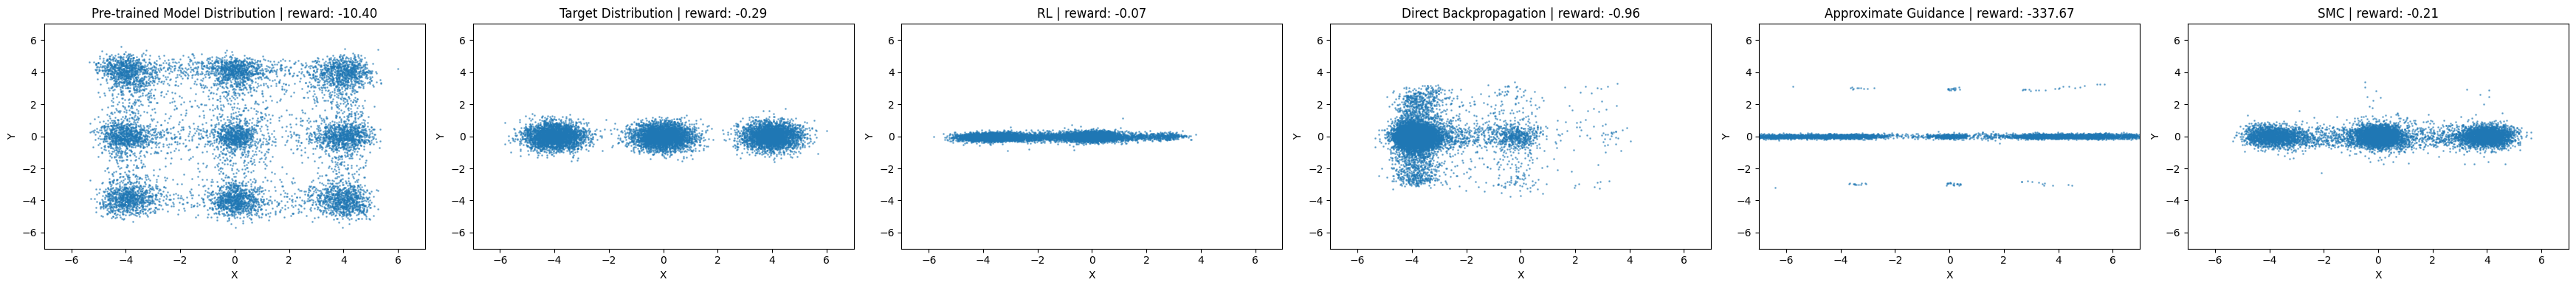

Figure saved as 'gaussian_mixture_1.png'


In [27]:
# Plot results
plt.figure(figsize=(35, 4))

# Set common axis limits
x_min, x_max = -7, 7
y_min, y_max = -7, 7

plt.subplot(1, 6, 1)
plt.scatter(pre_trained_samples[:, 0], pre_trained_samples[:, 1], alpha=0.5, s=1)
plt.title(f'Pre-trained Model Distribution | reward: {pre_trained_reward:.2f}')
plt.xlabel('X')
plt.ylabel('Y')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.subplot(1, 6, 2)
plt.scatter(target_samples[:, 0], target_samples[:, 1], alpha=0.5, s=1)
plt.title(f'Target Distribution | reward: {target_reward:.2f}')
plt.xlabel('X')
plt.ylabel('Y')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.subplot(1, 6, 3)
plt.scatter(rl_samples[:, 0], rl_samples[:, 1], alpha=0.5, s=1)
plt.title(f'RL | reward: {rl_reward:.2f}')
plt.xlabel('X')
plt.ylabel('Y')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.subplot(1, 6, 4)
plt.scatter(backprop_samples[:, 0], backprop_samples[:, 1], alpha=0.5, s=1)
plt.title(f'Direct Backpropagation | reward: {backprop_reward:.2f}')
plt.xlabel('X')
plt.ylabel('Y')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.subplot(1, 6, 5)
plt.scatter(guidance_samples[:, 0], guidance_samples[:, 1], alpha=0.5, s=1)
plt.title(f'Approximate Guidance | reward: {guidance_reward:.2f}')
plt.xlabel('X')
plt.ylabel('Y')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.subplot(1, 6, 6)
plt.scatter(smc_samples[:, 0], smc_samples[:, 1], alpha=0.5, s=1)
plt.title(f'SMC | reward: {smc_reward:.2f}')
plt.xlabel('X')
plt.ylabel('Y')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.tight_layout()

# Save the figure
plt.savefig('gaussian_mixture_1.png', dpi=300, bbox_inches='tight')

plt.show()
plt.close()

print("Figure saved as 'gaussian_mixture_1.png'")

In [28]:
from scipy.stats import wasserstein_distance_nd as WD
from numpy.random import choice

rl_emd = WD(rl_samples[choice(np.arange(len(rl_samples)), 500)], target_samples[choice(np.arange(len(target_samples)), 500)])
backprop_emd = WD(backprop_samples[choice(np.arange(len(backprop_samples)), 500)], target_samples[choice(np.arange(len(target_samples)), 500)])
guidance_emd = WD(guidance_samples[choice(np.arange(len(guidance_samples)), 500)], target_samples[choice(np.arange(len(target_samples)), 500)])
smc_emd = WD(smc_samples[choice(np.arange(len(smc_samples)), 500)], target_samples[choice(np.arange(len(target_samples)), 500)])